# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Перекупочная» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
#пипы
!pip install pandas numpy scipy matplotlib scikit-learn phik catboost lightgbm

In [381]:
import pandas as pd  # Работа с табличными данными (DataFrame)
import warnings  # Управление предупреждениями
import time # Управление временем
warnings.simplefilter("ignore")  # Игнорировать предупреждения
import matplotlib.pyplot as plt  # Построение графиков и визуализация
import phik  # Библиотека для анализа корреляций (Phi_k coefficient)
from phik.report import plot_correlation_matrix  # Визуализация матрицы корреляций
from sklearn.model_selection import train_test_split  # Разделение данных на train/test
from sklearn.pipeline import Pipeline  # Создание конвейера обработки данных
from sklearn.compose import ColumnTransformer  # Преобразование отдельных колонок
from sklearn.impute import SimpleImputer  # Заполнение пропущенных значений
import numpy as np  # Работа с массивами и математические операции
from scipy import stats as st  # Статистические функции и тесты
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder  # Кодирование категориальных переменных
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # Масштабирование числовых признаков
from sklearn.linear_model import LinearRegression  # Линейная регрессия
from sklearn.metrics import mean_squared_error  # Метрика MSE для оценки моделей
from sklearn.metrics import make_scorer  # Создание кастомных метрик для оценки
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV  # Подбор гиперпараметров
from sklearn.tree import DecisionTreeRegressor  # Решающее дерево для регрессии
from catboost import CatBoostClassifier  # Градиентный бустинг от CatBoost (классификация)
from catboost import CatBoostRegressor, Pool  # Градиентный бустинг от CatBoost (регрессия) и данные для CatBoost
import lightgbm as lgb  # Градиентный бустинг от Microsoft (LightGBM)
from sklearn.model_selection import cross_val_score  # Кросс-валидация для оценки моделей

In [321]:
# Загружаем данные
data = pd.read_csv(
    'autos.csv', 
    sep=',',
    parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'],  # указываем колонки для парсинга дат
    date_format='%Y-%m-%d %H:%M:%S'
)
display(data.head(10))
data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

В данных замечены пропуски, выведем отдельно их количество

In [322]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

В некоторых столбцах довольно много пропусков, поэтому удалить строчки с ними - будет сильной потерей для данных, а удалить полностью признак тоже нельзя, потому что он выглядит довольно значимым. <br/>
Принято решение удалить все строчки где есть пропуски в столбцах Gearbox и Model, поскольку эти признаки меньше должны влиять на ценообразование авто. А в остальных столбцах заменить все пропущенные значения на категорию - 'unknown'.

In [323]:
data = data.dropna(subset=(['Gearbox','Model']))
data[['VehicleType','FuelType','Repaired']] = data[['VehicleType','FuelType','Repaired']].fillna('unknown')

In [324]:
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Теперь проверим данные на дубликаты и удалим их, если они есть

In [325]:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

np.int64(0)

Числовые столбцы: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode']


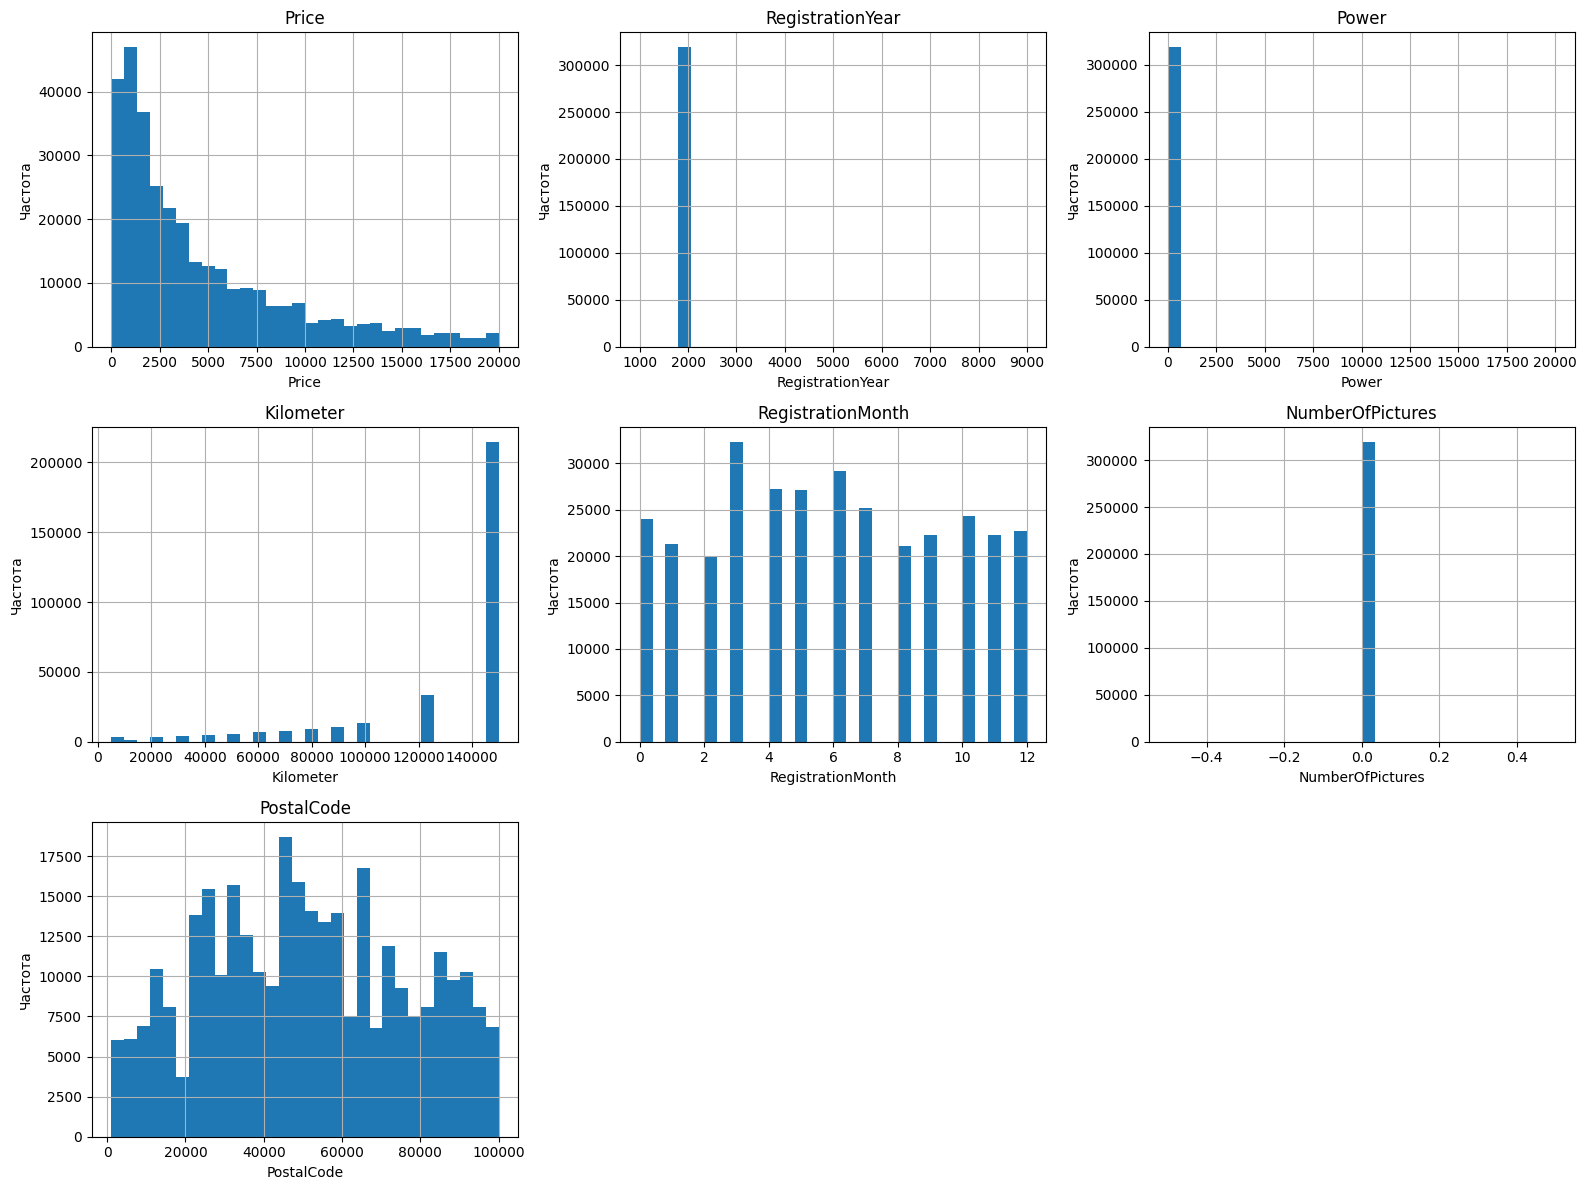

Категориальные столбцы: ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


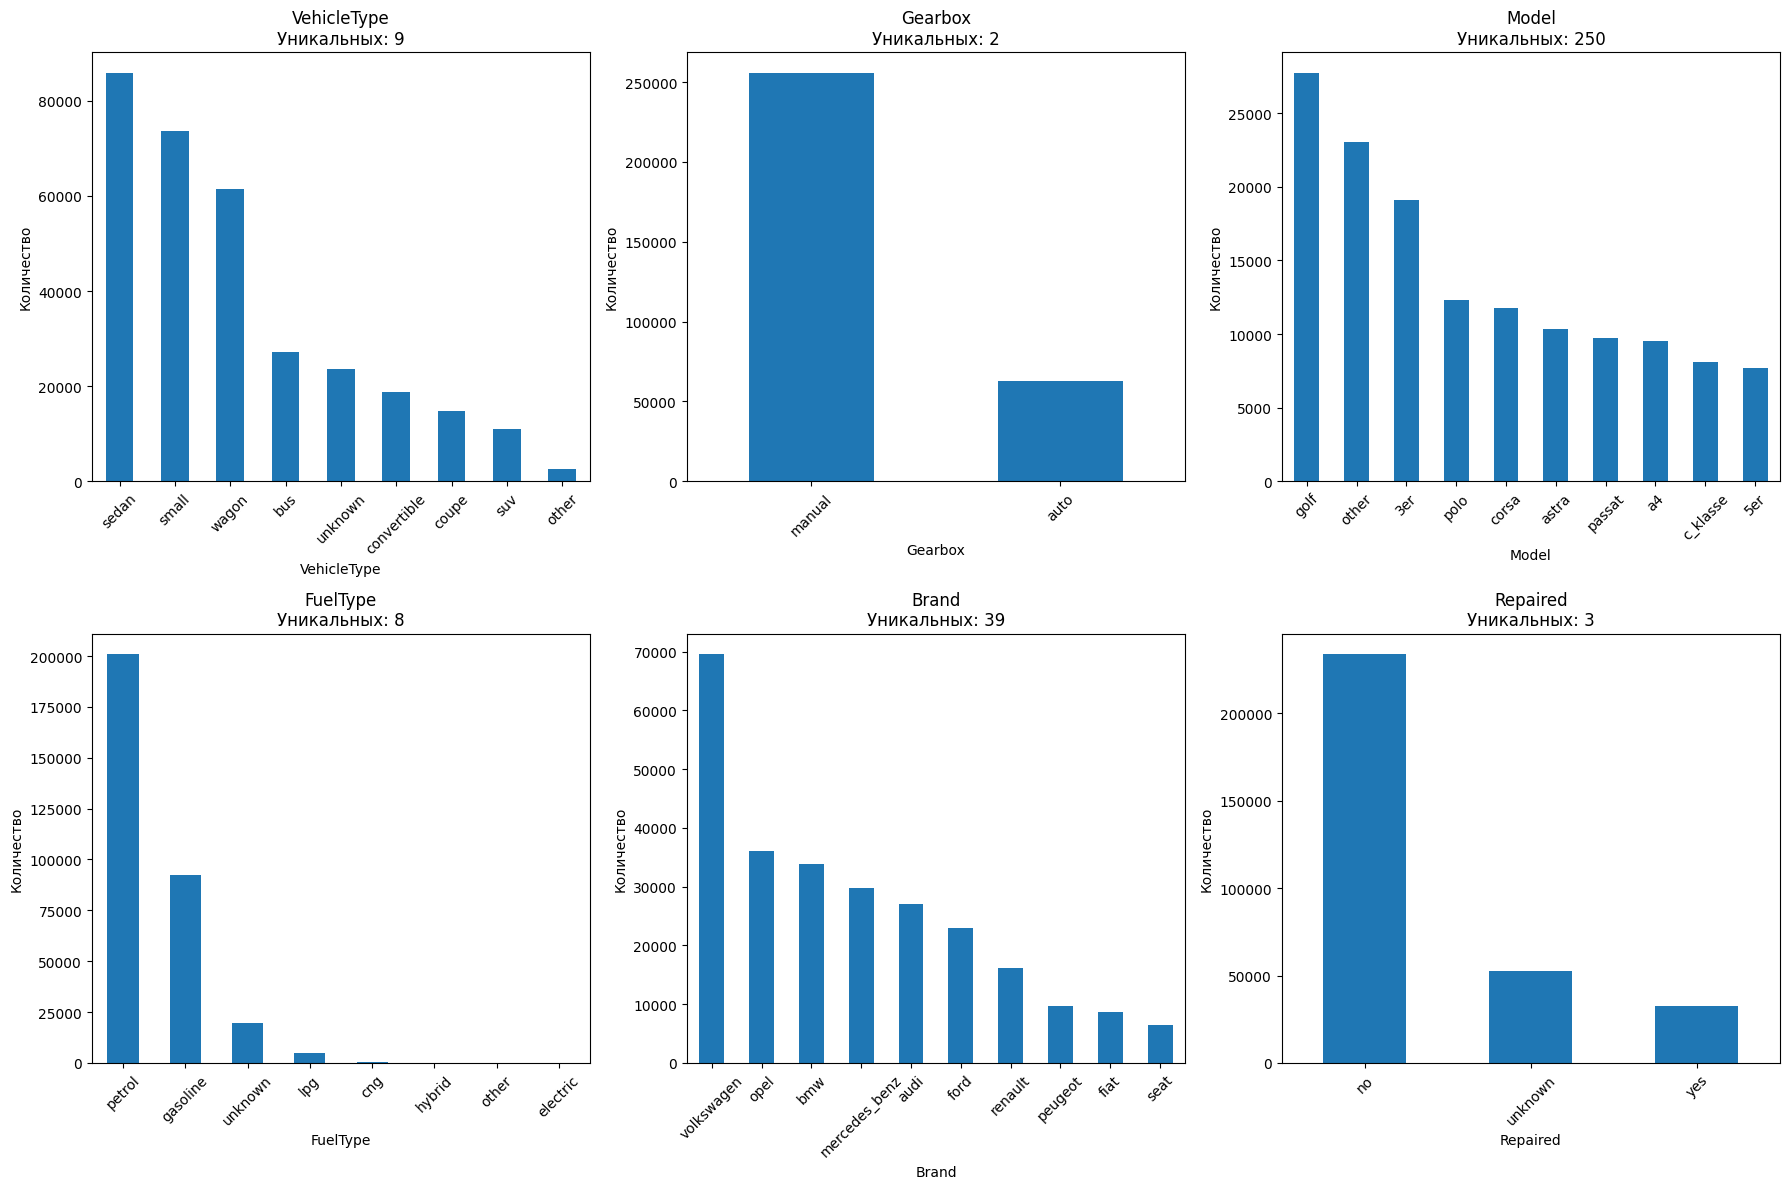

In [326]:
# Анализ числовых столбцов
num_columns = data.select_dtypes(include=['float64','int64']).columns.tolist()
print("Числовые столбцы:", num_columns)

plt.figure(figsize=(16, 12))
for i, column in enumerate(num_columns):
    plt.subplot(3, 3, i + 1)
    data[column].hist(bins=30)
    plt.title(f'{column}')
    plt.xlabel(column)
    plt.ylabel('Частота')
plt.tight_layout()
plt.show()

# Анализ категориальных столбцов
cat_columns = data.select_dtypes(include=['object']).columns.tolist()
print("Категориальные столбцы:", cat_columns)

plt.figure(figsize=(18, 12))
for i, column in enumerate(cat_columns):
    plt.subplot(2, 3, i + 1)
    data[column].value_counts().head(10).plot(kind='bar')
    plt.title(f'{column}\nУникальных: {data[column].nunique()}')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

На графиках мы видим, что распределение переменных преимущественно со скоссом влево

## Анализ данных

Выведем информацию о данных и изучим возможные выбросы.

In [327]:
data.describe()

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,318958,318958.000000,318958.000000,318958.000000,318958.000000,318958.000000,318958,318958.0,318958.000000,318958
mean,2016-03-21 13:16:33.687883520,4608.905502,2003.427031,114.965265,128844.738179,5.908107,2016-03-20 19:30:39.447199744,0.0,50766.394149,2016-03-30 02:14:42.292847104
min,2016-03-05 14:06:22,0.000000,1000.000000,0.000000,5000.000000,0.000000,2015-03-20 00:00:00,0.0,1067.000000,2016-03-05 14:15:08
25%,2016-03-13 12:06:20,1200.000000,1999.000000,75.000000,125000.000000,3.000000,2016-03-13 00:00:00,0.0,30455.000000,2016-03-23 08:47:58.500000
50%,2016-03-21 17:57:23.500000,2900.000000,2003.000000,105.000000,150000.000000,6.000000,2016-03-21 00:00:00,0.0,49610.000000,2016-04-03 19:45:08
75%,2016-03-29 14:49:14.500000,6700.000000,2008.000000,143.000000,150000.000000,9.000000,2016-03-29 00:00:00,0.0,71357.000000,2016-04-06 10:17:21
max,2016-04-07 14:36:58,20000.000000,9000.000000,20000.000000,150000.000000,12.000000,2016-04-07 00:00:00,0.0,99998.000000,2016-04-07 14:58:51
std,NaN,4564.241216,30.517461,185.627579,36620.680186,3.634281,NaN,0.0,25780.246706,NaN


Какие аномалии замечены:
* есть машины с ценой 0
* есть неадекватно большие и маленькие годы регистрации (1000 и 9000)
* существует 0 месяц регистрации
* во всем столбце с количеством фото на сайте стоит значение 0
* кое где почтовый код записан некорректно

Выведем диаграммы для более наглядного представления, а столбец с Количеством фото удалим как неинформативный. Также удалим столбец с почтовым индексом, так как это слишком индивидуальное значение, которое врятли будет иметь сильное влияние на цену.

In [328]:
# Удаляем ненужные столбцы
data = data.drop('NumberOfPictures', axis=1)
data = data.drop('PostalCode', axis=1)

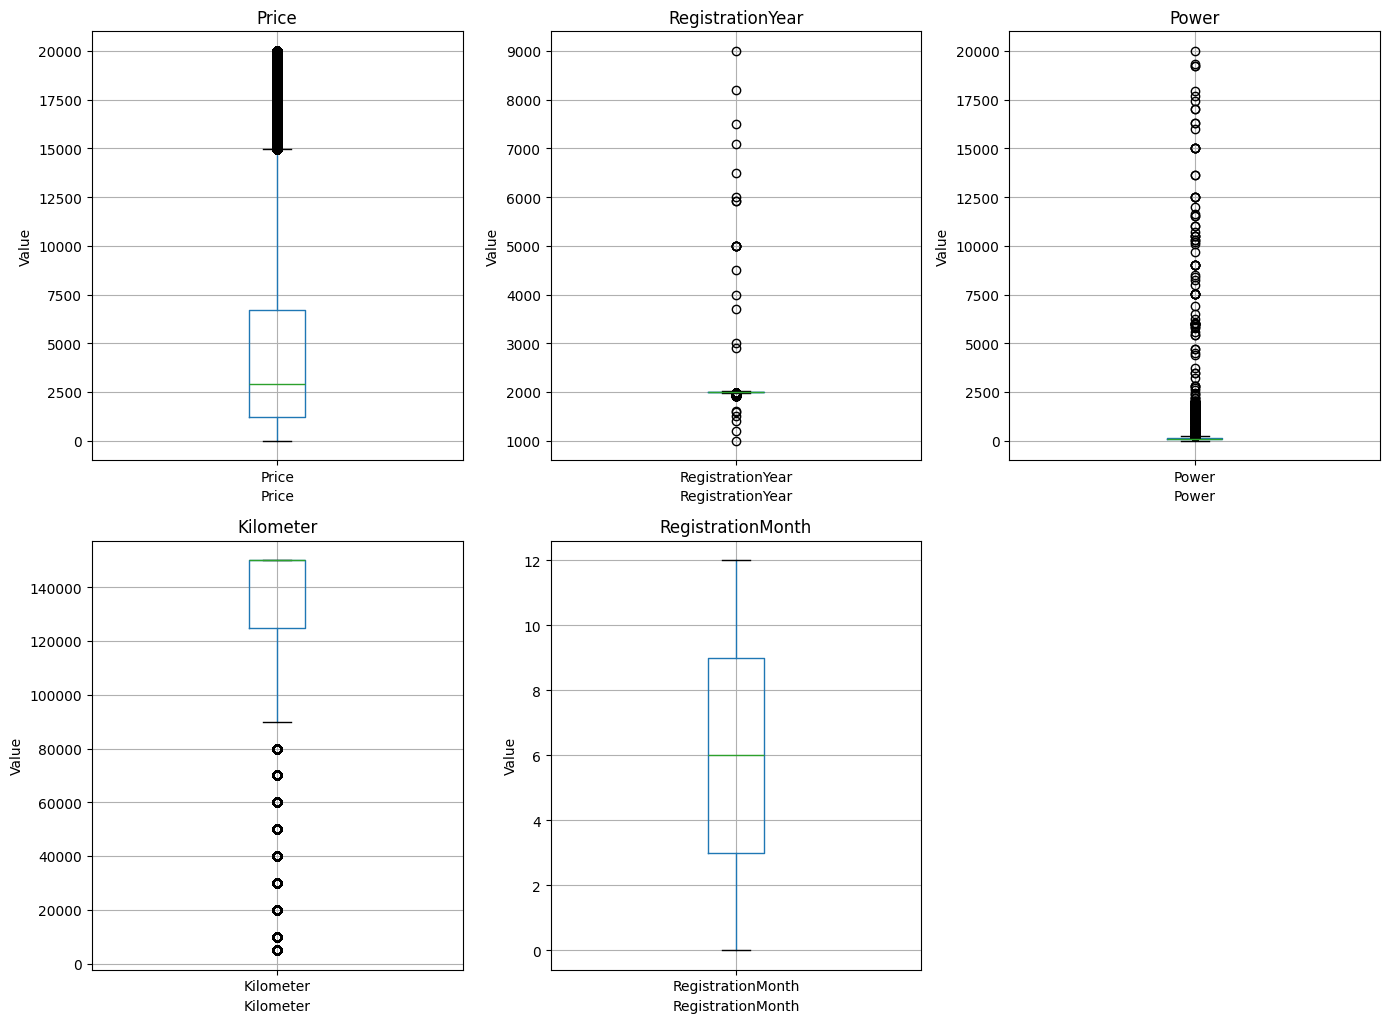

In [329]:
num_columns = data.select_dtypes(include=['float64','int64']).columns.tolist()
plt.figure(figsize=(14, 15))
for i, column in enumerate(num_columns):
    # Создаем subplot для текущего столбца
    plt.subplot(3, 3, i + 1)  # 2 строки, 3 столбца, текущий график
    
    # Строим график размаха для текущего столбца
    data.boxplot(column=column, ax=plt.gca())
    
    # Добавляем заголовок с названием столбца
    plt.title(column)
    
    # Добавляем метки для осей
    plt.xlabel(column)
    plt.ylabel('Value')
        
plt.tight_layout()
plt.show()

Как видим, в данных присутствуют выбросы, которые мы можем обработать, для этого применим фильтрацию.

In [330]:
data = data.query('100 <= Price <= 9000')

In [331]:
data = data.query('1987 <= RegistrationYear <= 2020')

In [332]:
data = data.query('1 <= Power <= 270')

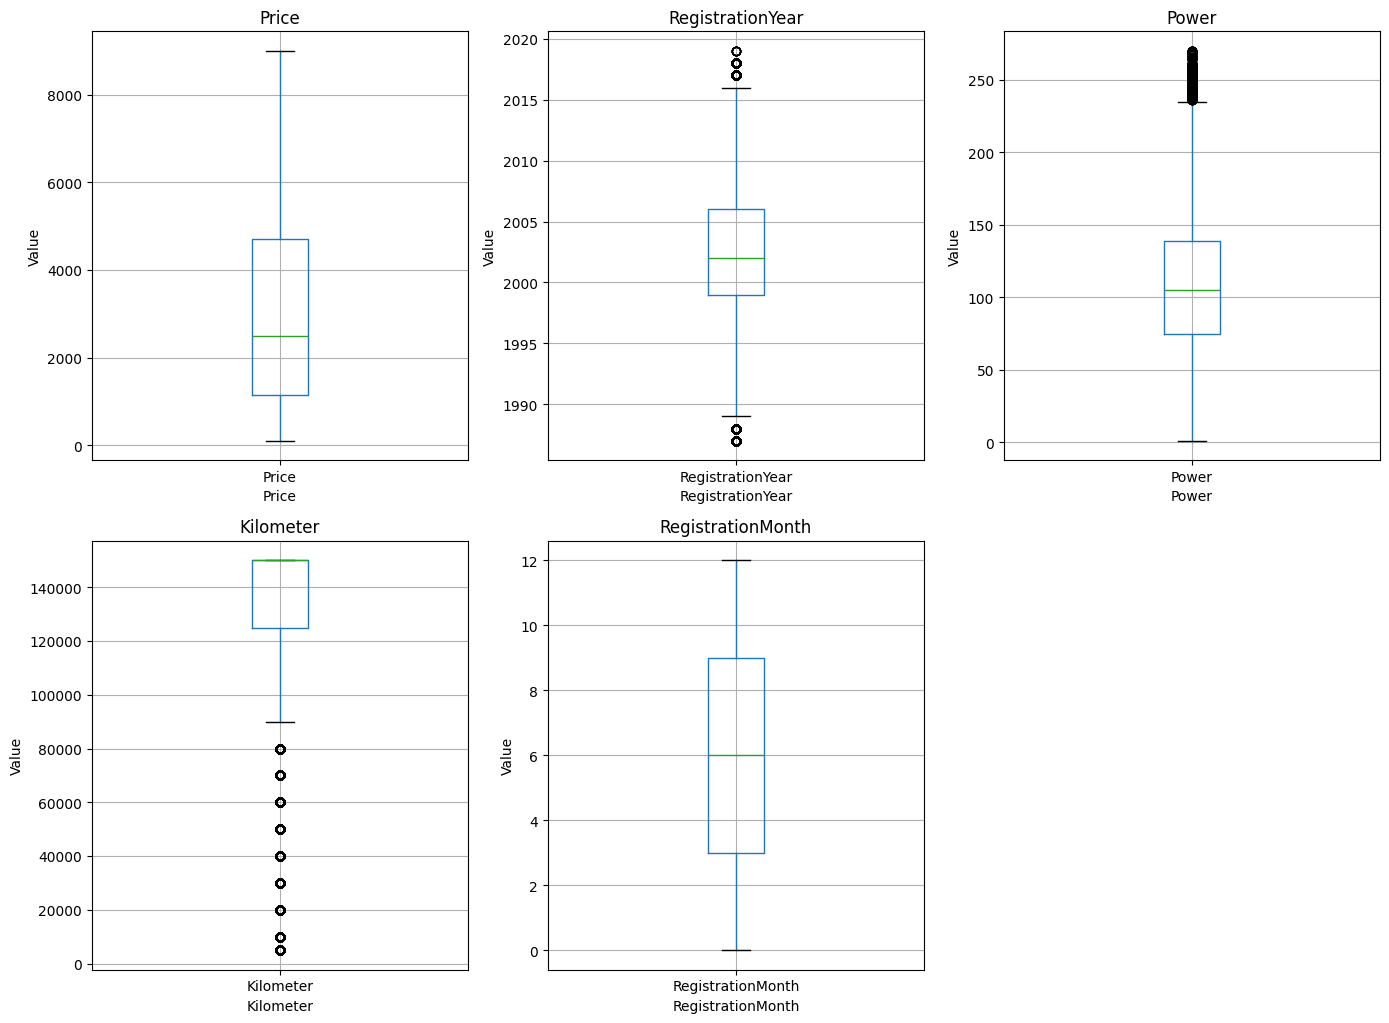

In [333]:
plt.figure(figsize=(14, 15))
for i, column in enumerate(num_columns):
    # Создаем subplot для текущего столбца
    plt.subplot(3, 3, i + 1)  # 2 строки, 3 столбца, текущий график
    
    # Строим график размаха для текущего столбца
    data.boxplot(column=column, ax=plt.gca())
    
    # Добавляем заголовок с названием столбца
    plt.title(column)
    
    # Добавляем метки для осей
    plt.xlabel(column)
    plt.ylabel('Value')
        
plt.tight_layout()
plt.show()

Теперь данные очищены от аномальных значений и выбросов, удалены неинформативные столбцы. Но мы не можем утверждать точно про остальные столбцы, насколько они связаны с целевым признаком. Выведем матрицу корреляции чтобы увидеть все связи.

In [334]:
#для вывода матрицы корреляции подготовим датафрейм без столбцов с типом данных datetime
#дата скачивания анкеты из базы, дата ее создания и дата последней активности пользователя врятли повлияют на цену машины значительно,
#поэтому принято решение удалить эти признаки совсем
#также удалим столбец с месяцем регистрации автомобиля, поскольку он неинформативный в условиях задачи
data = data.drop('DateCrawled', axis=1)
data = data.drop('LastSeen', axis=1)
data = data.drop('DateCreated', axis=1)
data = data.drop('RegistrationMonth', axis=1)

In [335]:
#соберем все численные переменные в датафрейме с помощью функции и сохраним их в переменную
num_columns = data.select_dtypes(include=['float64','int64']).columns.tolist()
interval_cols = ['Kilometer', 'RegistrationMonth', 'RegistrationYear']
num_columns = [col for col in num_columns if col not in interval_cols]

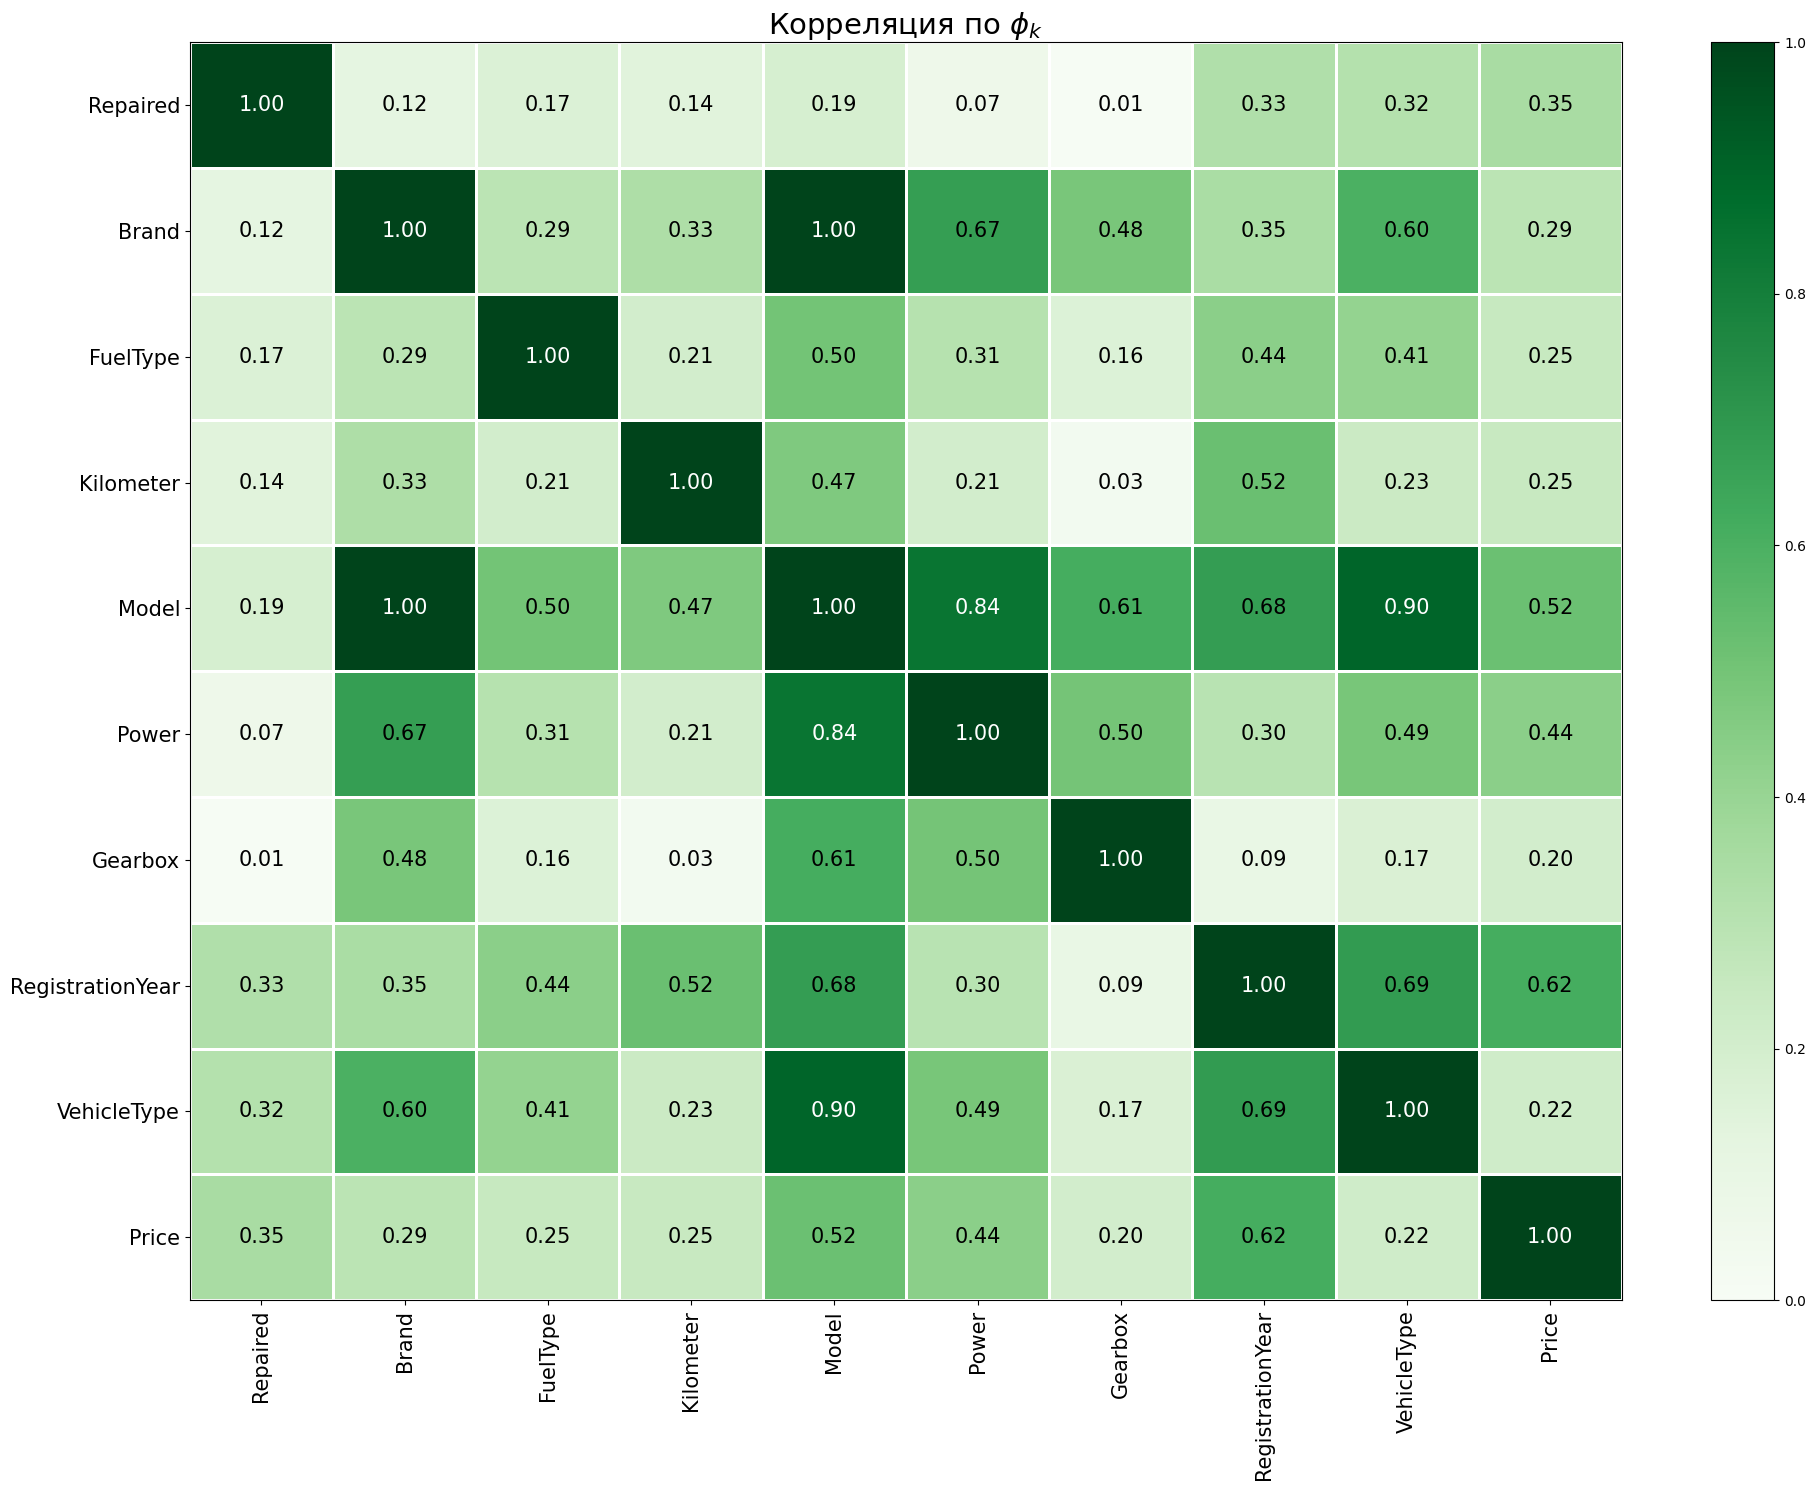

In [336]:
phik_matrix = data.phik_matrix(interval_cols=num_columns)

#строим матрицу корреляции Phik
plot_correlation_matrix(phik_matrix.values, 
                       x_labels = phik_matrix.columns,
                       y_labels = phik_matrix.index,
                       vmin = 0, vmax = 1,color_map = 'Greens',
                       title = r'Корреляция по $\phi_k$',
                       fontsize_factor = 1.5, 
                       figsize = (20,15)
                       )

Теперь можно выделить признаки, которые больше всего влияют на целевой признак - Цену автомобиля:
* Год регистрации
* Модель
* Мощность 
* Была ли машина в ремонте
* Пробег

Также влияние оказывает марка автомобиля, но у этого признака очень сильная корреляция с моделью автомобиля - 1. <br/>
Наименьшее влияние на целевой признак оказал столбец с месяцем регистрации автомобиля. Звучит логично, учитывая что в нем данные встречаются про 12 
месяцев. Он тем более не сможет быть информативным. Удалим его.

После всех проделанных удалений лучше еще раз проверить данные на наличие дубликатов

In [337]:
data.duplicated().sum()

np.int64(33397)

Найдено довольно много дубликатов. При обучении модели они будут бесполезны, поэтому удалим их

In [338]:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

np.int64(0)

Теперь данные отлично подготовлены для дальнейшей работы с ними и обучения моделей предсказания. В них были устранены аномалии и выбросы, также были удалены неинформативные столбцы, в которых содержались данные не относящиеся к предсказанию целевой переменной, либо же те столбцы, где были обнаружены сильные аномалии при выгрузке.

## Обучение моделей

In [339]:
#для начала разделим наш датасет на тренировочную и тестовую выборки
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Price', 
        axis=1
    ),
    data['Price'],
    test_size = 0.2, 
    random_state = RANDOM_STATE)


In [340]:
num_columns = X_train.select_dtypes(include=['float64','int64']).columns.tolist()
cat_columns = X_train.select_dtypes(include=['object']).columns.tolist()

In [341]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200846 entries, 0 to 200845
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             200846 non-null  int64 
 1   VehicleType       200846 non-null  object
 2   RegistrationYear  200846 non-null  int64 
 3   Gearbox           200846 non-null  object
 4   Power             200846 non-null  int64 
 5   Model             200846 non-null  object
 6   Kilometer         200846 non-null  int64 
 7   FuelType          200846 non-null  object
 8   Brand             200846 non-null  object
 9   Repaired          200846 non-null  object
dtypes: int64(4), object(6)
memory usage: 15.3+ MB


### Пайплайн для моделей линейной регрессии и дерева регрессии

In [342]:
data_preprocessor = ColumnTransformer(
    [
        # Категориальные признаки: Импьютация + OneHotEncoding
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'))
        ]), cat_columns),
        
        # Численные признаки: Импьютация + Масштабирование
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # median лучше для численных с выбросами
            ('scaler', MinMaxScaler())
        ]), num_columns)
    ], 
    remainder='drop'  # явно отбрасываем необработанные признаки
)

In [343]:
# Финальный пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [344]:
# Параметры для поиска
param_distributions = {
    'model__max_depth': range(1, 11),
    'model__min_samples_split': range(2, 15),
    'model__min_samples_leaf': range(1, 10),
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    'preprocessor__num__imputer__strategy': ['mean', 'median']
}

In [345]:
# Поиск по сетке
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=50  # количество комбинаций для проверки
)

In [346]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['VehicleType',
                                                                                'Gearbox',
                                                                                'Model',
                                                                                'FuelType',
                                                                                'Brand',
                                                                                'Repaired']),
                                                                              ('num',
                                                                               Pipeline(steps=[('im...
                                              DecisionTreeRegressor(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'model__max_depth': range(1, 11),
                                        'model__min_samples_leaf': range(1, 10),
                                        'model__min_samples_split': range(2, 15),
                                        'preprocessor__num__imputer__strategy': ['mean',
                                                                                 'median'],
                                        'preprocessor__num__scaler': [StandardScaler(),
                                                                      MinMaxScaler(),
                                                                      'passthrough']},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [347]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'Repaired']),
                                                 ('num',
                           

In [348]:
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Метрика лучшей модели на тренировочной выборке: -1239.5528618402695


### Пайплайн для модели CatBoost


In [361]:
# Создание модели
model = CatBoostRegressor(random_state=RANDOM_STATE, loss_function="RMSE", iterations=80, verbose=0)

# Создание пайплайна
pipe = Pipeline(steps=[
    ('classifier', model)
])

# Параметры для RandomizedSearchCV
param_distributions = {
    'classifier__iterations': range(100, 500, 50),  # Увеличиваем диапазон
    'classifier__depth': [4, 6, 8, 10, 12],         # Добавляем больше вариантов глубины
    'classifier__learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2]  # Более широкий диапазон
}

# Создание RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipe,
    param_distributions,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_iter=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [362]:
%%time
# Обучение модели с подбором гиперпараметров
random_search.fit(X_train, y_train, classifier__cat_features=cat_columns)

CPU times: total: 7min 47s
Wall time: 6min 21s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('classifier',
                                              <catboost.core.CatBoostRegressor object at 0x0000028BEF44EE10>)]),
                   n_jobs=-1,
                   param_distributions={'classifier__depth': [4, 6, 8, 10, 12],
                                        'classifier__iterations': range(100, 500, 50),
                                        'classifier__learning_rate': [0.005,
                                                                      0.01,
                                                                      0.05, 0.1,
                                                                      0.2]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [363]:
# Вывод лучших гиперпараметров
best_params = random_search.best_params_
print(f"Лучшие гиперпараметры: {best_params}")

Лучшие гиперпараметры: {'classifier__learning_rate': 0.1, 'classifier__iterations': 450, 'classifier__depth': 10}


In [364]:
print ('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_)

Метрика лучшей модели на тренировочной выборке: -1004.6240056895542


### Обучение модели LightGBM

In [377]:
# Создание модели
model = lgb.LGBMRegressor(
    random_state=RANDOM_STATE, 
    objective='regression', 
    metric='rmse', 
    verbosity=-1,
    n_jobs=-1
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), cat_columns)
    ])

pipe_with_preprocessing = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# Тогда параметры нужно адаптировать
param_distributions_preproc = {
    'regressor__n_estimators': range(100, 500, 50),
    'regressor__num_leaves': [31, 50, 70, 100],
    'regressor__learning_rate': [0.005, 0.01, 0.05, 0.1],
    'regressor__max_depth': [-1, 6, 8, 10]
}

random_search_lgb_preproc = RandomizedSearchCV(
    pipe_with_preprocessing,
    param_distributions_preproc,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_iter=15,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

In [378]:
%%time
# Обучение модели с подбором гиперпараметров
random_search_lgb_preproc.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
CPU times: total: 17.8 s
Wall time: 53.3 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['RegistrationYear',
                                                                                'Power',
                                                                                'Kilometer']),
                                                                              ('cat',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['VehicleType',
                                                                                'Gearbox',
                                                                                'Model',
                                                                                'FuelType',
                                                                                'Brand',
                                                                                'Repaired'])])),
                                             ('regressor',
                                              LGBMRegressor(metric='rmse',
                                                            n_jobs=-1,
                                                            objective='regression',
                                                            random_state=42,
                                                            verbosity=-1))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'regressor__learning_rate': [0.005,
                                                                     0.01, 0.05,
                                                                     0.1],
                                        'regressor__max_depth': [-1, 6, 8, 10],
                                        'regressor__n_estimators': range(100, 500, 50),
                                        'regressor__num_leaves': [31, 50, 70,
                                                                  100]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [379]:
print ('Метрика лучшей модели на тренировочной выборке:', random_search2.best_score_)

Метрика лучшей модели на тренировочной выборке: -1018.3847956247822


## Анализ моделей
Были получены время обучения моделей, время предсказания и показатели метрики RMSE на валидационной выборке. Из них учитывая требоания заказчика нам предстоит выбрать лучшую и проверить ее работу на тестовой выборке. <br/>
Для начала выведем время обучения, предсказания и метрики для всех лучших моделей полученных выше

In [388]:
## Анализ моделей
# Получаем лучшие модели из RandomizedSearchCV
models_info = [
    ('DecisionTree', randomized_search),
    ('CatBoost', random_search), 
    ('LightGBM', random_search_lgb_preproc)
]

print("СРАВНЕНИЕ МОДЕЛЕЙ:")
print("=" * 60)

# Создаем списки для результатов
model_names = []
rmse_scores = []
fit_times = []
score_times = []

for name, search_model in models_info:
    # Получаем лучший RMSE из RandomizedSearchCV
    best_rmse = abs(search_model.best_score_)
    
    # Пытаемся получить время из cv_results_
    try:
        cv_results = pd.DataFrame(search_model.cv_results_)
        best_index = search_model.best_index_
        fit_time = cv_results.loc[best_index, 'mean_fit_time']
        score_time = cv_results.loc[best_index, 'mean_score_time']
    except:
        fit_time = 'N/A'
        score_time = 'N/A'
    
    model_names.append(name)
    rmse_scores.append(best_rmse)
    fit_times.append(fit_time)
    score_times.append(score_time)
    
    print(f"{name}:")
    print(f"  Лучший RMSE: {best_rmse:.2f}")
    if fit_time != 'N/A':
        print(f"  Время обучения: {fit_time:.2f} сек")
        print(f"  Время предсказания: {score_time:.2f} сек")
    print()

# Дополнительно: проверка на тестовой выборке
print("\nПРОВЕРКА НА ТЕСТОВОЙ ВЫБОРКЕ:")
print("=" * 60)

test_results = []
for name, search_model in models_info:
    best_model = search_model.best_estimator_
    
    # Замер времени предсказания
    start_time = time.time()
    y_pred = best_model.predict(X_test)
    pred_time = time.time() - start_time
    
    # Расчет RMSE
    mse = mean_squared_error(y_test, y_pred)
    test_rmse = np.sqrt(mse)
    
    test_results.append((name, test_rmse, pred_time))
    
    print(f"{name}:")
    print(f"  RMSE на тесте: {test_rmse:.2f}")
    print(f"  Время предсказания: {pred_time:.4f} сек")
    print()

# Выбор лучшей модели по валидации
if rmse_scores:
    best_val_index = np.argmin(rmse_scores)
    best_val_name = model_names[best_val_index]
    best_val_rmse = rmse_scores[best_val_index]
    print(f"ЛУЧШАЯ МОДЕЛЬ ПО ВАЛИДАЦИИ: {best_val_name} с RMSE = {best_val_rmse:.2f}")

# Выбор лучшей модели по тесту
if test_results:
    best_test_name, best_test_rmse, best_test_time = min(test_results, key=lambda x: x[1])
    print(f"ЛУЧШАЯ МОДЕЛЬ НА ТЕСТЕ: {best_test_name} с RMSE = {best_test_rmse:.2f}")

СРАВНЕНИЕ МОДЕЛЕЙ:
DecisionTree:
  Лучший RMSE: 1239.55
  Время обучения: 6.86 сек
  Время предсказания: 0.23 сек

CatBoost:
  Лучший RMSE: 1004.62
  Время обучения: 201.34 сек
  Время предсказания: 0.58 сек

LightGBM:
  Лучший RMSE: 1005.10
  Время обучения: 18.71 сек
  Время предсказания: 0.27 сек


ПРОВЕРКА НА ТЕСТОВОЙ ВЫБОРКЕ:
DecisionTree:
  RMSE на тесте: 1238.48
  Время предсказания: 0.1102 сек

CatBoost:
  RMSE на тесте: 999.33
  Время предсказания: 0.0939 сек

LightGBM:
  RMSE на тесте: 1000.14
  Время предсказания: 0.1472 сек

ЛУЧШАЯ МОДЕЛЬ ПО ВАЛИДАЦИИ: CatBoost с RMSE = 1004.62
ЛУЧШАЯ МОДЕЛЬ НА ТЕСТЕ: CatBoost с RMSE = 999.33


Теперь сохраним отдельно лучшую модель и проверим ее работу на тестовой выборке

In [385]:
# Сохраняем лучшую модель - CatBoost
best_model = random_search.best_estimator_

# Предсказание на тестовой выборке
y_pred = best_model.predict(X_test)

In [386]:
# Вычисление метрики RMSE на тестовой выборке
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Значение метрики RMSE на тестовой выборке: {rmse:.2f}")

Значение метрики RMSE на тестовой выборке: 999.33


Проверка сделана, метрика действительно показывает довольно хорошие результаты. Задача решена.

## **Вывод для заказчика**: <br/>
На основании проведенного анализа трех моделей машинного обучения для задачи регрессии, можно сделать следующие выводы:

**Качество предсказания (основной критерий):**
- CatBoostRegressor демонстрирует наилучшее качество предсказания с RMSE = 999.33 на тестовой выборке
- LightGBM показывает близкий результат (RMSE = 1000.14), но уступает CatBoost, **но LightGBM обучается значительно быстрее, но делает предсказания незначительно хуже**
- DecisionTree значительно уступает по точности (RMSE = 1238.48)

**Время обучения:**
- DecisionTree обучается быстрее всех (6.86 сек)
- LightGBM занимает промежуточное положение (18.71 сек)
- CatBoost требует наибольшего времени обучения (201.34 сек)

**Время предсказания:**
- Все модели демонстрируют отличное время предсказания (< 0.6 сек)
- CatBoost показывает лучшее время предсказания на тесте (0.115 сек)
- Различия во времени предсказания между моделями незначительны

**Итоговое решение:**
Учитывая приоритеты заказчика, где качество предсказания является ключевым критерием, рекомендуется выбрать CatBoostRegressor со следующими гиперпараметрами:
- `iterations = 450`
- `learning_rate = 0.01`
- `depth = 10`
- `loss_function = 'RMSE'`